# PyTorch MNIST Classifier - Local Example

_**Train and export a PyTorch CNN classifier for (a subset of) the [MNIST DIGITS](https://en.wikipedia.org/wiki/MNIST_database) dataset: Performing all storage and computation locally on the notebook.**_

This notebook works well with the `Python 3 (PyTorch 1.4 Python 3.6 CPU Optimized)` kernel on SageMaker Studio, or `conda_pytorch_p36` on classic SageMaker Notebook Instances.

---

To give a better idea of how you might **apply the example to real-world problems**, we **convert the dataset** from its standard pixel array format to a "folders of JPEGs" setting more typical in image classification projects just starting out. For MNIST (where the images are all tiny and uniform size), this is a much less efficient storage method - so we sample a subset of the data to keep things performant.

>❓*Can you figure out how to re-create this notebook's workflow using SageMaker more effectively?*

## Contents

1. [Explore the Data](#Explore-the-Data)
1. [Convert the Data Format](#Convert-the-Data-Format)
1. **[Load the Data From File](#Load-the-Data-From-File)** *
1. **[Pre-Process the Data for our CNN](#Pre-Process-the-Data-for-our-CNN)** *
1. **[Build a Model](#Build-a-Model)** *
1. **[Fit the Model](#Fit-the-Model)** *
1. **[Save the Trained Model](#Save-the-Trained-Model)** *
1. [Explore Results](#Explore-Results)

See the accompanying **Instructions** notebook for more guidance!


In [1]:
# First install some libraries which might not be available across all kernels (e.g. in Studio):
!pip install ipywidgets

  Using cached ipywidgets-7.6.3-py2.py3-none-any.whl (121 kB)
  Using cached widgetsnbextension-3.5.1-py2.py3-none-any.whl (2.2 MB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jupyterlab_widgets-1.0.0-py3-none-any.whl (243 kB)
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached pyrsistent-0.17.3-cp36-cp36m-linux_x86_64.whl
  Using cached notebook-6.3.0-py3-none-any.whl (9.5 MB)
  Using cached prometheus_client-0.10.1-py2.py3-none-any.whl (55 kB)
  Using cached Send2Trash-1.5.0-py3-none-any.whl (12 kB)
  Using cached terminado-0.9.4-py3-none-any.whl (14 kB)
  Using cached tornado-6.1-cp36-cp36m-manylinux2010_x86_64.whl (427 kB)
  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Using cached argon2_cffi-20.1.0-cp35-abi3-manylinux1_x86_64.whl (97 kB)
  Using cached bleach-3.3.0-py2.py3-none-any.whl (283 kB)
  Using cached mistune-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached entrypoints-0.3-py2.py3-none-any.whl (11 kB)
  Using

If you are on SageMaker Studio, please restart the kernel after the above cell

In [1]:
# matplotlib may not be installed by default on some kernels (e.g. SMStudio TF CPU Optimized)
!pip install matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

print(f"Using PyTorch version {torch.__version__}")

Using PyTorch version 1.4.0


## Explore the Data

Let's use the Keras built-in to load the MNIST data, but explore exactly what format that gives us:


x_train.shape (25200, 28, 28); dtype uint8
y_train.shape (25200,); dtype int64
x_test.shape (4800, 28, 28); dtype uint8
y_test.shape (4800,); dtype int64


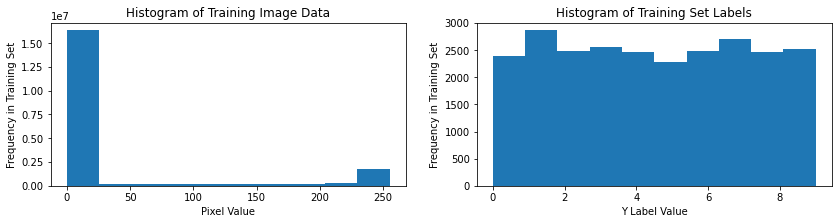

In [3]:
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

# To keep things snappy for the exercise (you'll see why later), we will scale back the data:
usable = int(len(mnist_dataset)/2)
train_set, delete_set = torch.utils.data.random_split(mnist_dataset, [usable, len(mnist_dataset)-usable])
del delete_set

train_part = int(0.84*usable)
train_set, test_set = torch.utils.data.random_split(train_set, [train_part, usable-train_part])
x_train_raw, y_train_raw = map(list,zip(*train_set))
x_test_raw, y_test_raw = map(list,zip(*test_set))

x_train_raw = list(map(np.asarray,x_train_raw))
x_train_raw = np.array(x_train_raw)
y_train_raw = np.array(y_train_raw)
x_test_raw = list(map(np.asarray,x_test_raw))
x_test_raw = np.array(x_test_raw)
y_test_raw = np.array(y_test_raw)

print(f"x_train.shape {x_train_raw.shape}; dtype {x_train_raw.dtype}")
print(f"y_train.shape {y_train_raw.shape}; dtype {y_train_raw.dtype}")
print(f"x_test.shape {x_test_raw.shape}; dtype {x_test_raw.dtype}")
print(f"y_test.shape {y_test_raw.shape}; dtype {y_test_raw.dtype}")

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.hist(x_train_raw.flatten())
ax.set_title("Histogram of Training Image Data")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Pixel Value")

ax = plt.subplot(1, 2, 2)
plt.hist(y_train_raw)
ax.set_title("Histogram of Training Set Labels")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Y Label Value")

plt.show()

It looks like the data is pretty evenly distributed between labels 0-9, and our images are encoded by fixed-size 28x28 uint8 matrices from 0 to 255. Here we'll just plot a few examples to get a feel for them:


Some example images:


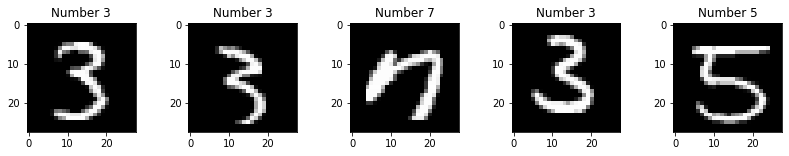

In [4]:
print("Some example images:")
fig = plt.figure(figsize=(14, 2))
for i in range(5):
    fig = plt.subplot(1, 5, i + 1)
    ax = plt.imshow(x_train_raw[i], cmap="gray")
    fig.set_title(f"Number {y_train_raw[i]}")
plt.show()

## Convert the Data Format

Now let's create a folder for each class 0-9, and save all the images in their associated folder... It's a bit easier to relate to than the pre-prepared numpy arrays!


In [5]:
import os

In [6]:
%%time
!rm -rf data/train
!rm -rf data/test

# This can take a while due to the number of images
def save_to_disk(x, y, base_folder):
    transform = torchvision.transforms.ToPILImage("L")
    """Save an image classification dataset to disk as JPEGs in label-named folders"""
    for ix in range(len(y)):
        label_str = "digit-%d" % y[ix]
        os.makedirs(os.path.join(base_folder, label_str), exist_ok=True)
        transform(x[ix]).save(os.path.join(base_folder, label_str, "%s-%06d.jpg" % (label_str, ix)))

print("Saving training data...")
os.makedirs("data/train", exist_ok=True)
save_to_disk(x_train_raw, y_train_raw, "data/train")
print("Saving test data...")
os.makedirs("data/test", exist_ok=True)
save_to_disk(x_test_raw, y_test_raw, "data/test")
print("Done!")

Saving training data...
Saving test data...
Done!
CPU times: user 13.3 s, sys: 4.65 s, total: 17.9 s
Wall time: 6min 31s


## Load the Data From File

Now our images are stored in the `data/` folder, let's ignore the Keras built-in method and read our training and test sets in from these files.

```
    ./data
    |----------------.
    `-- test          `-- train
        |-- digit-0       |-- digit-0
        |                     `-- digit-0-000001.jpg, etc.
        |-- digit-1       |-- digit-1
        |-- digit-2       |-- digit-2
        |-- digit-3       |-- digit-3
        |-- digit-4       |-- digit-4
        |-- digit-5       |-- digit-5
        |-- digit-6       |-- digit-6
        |-- digit-7       |-- digit-7
        |-- digit-8       |-- digit-8
        `-- digit-9       `-- digit-9
```

(For both training and test) We'll loop through each folder taking the target label (`0`-`9`) from the folder name and loading loading each JPEG into an image matrix.


In [7]:
from PIL import Image
labels = sorted(os.listdir("data/train"))
n_labels = len(labels)

x_train = []
y_train = []
x_test = []
y_test = []
print("Loading label ", end="")
for ix_label in range(n_labels):
    label_str = labels[ix_label]
    print(f"{label_str}...", end="")
    trainfiles = filter(
        lambda s: s.endswith(".jpg"),
        os.listdir(os.path.join("data/train", label_str))
    )
    for filename in trainfiles:
        with open(os.path.join("data/train", label_str, filename), "rb") as imgfile:
            x_train.append(
                np.squeeze(np.asarray(
                    Image.open(imgfile)
                ))
            )
            y_train.append(ix_label)
    # Repeat for test data:
    testfiles = filter(
        lambda s: s.endswith(".jpg"),
        os.listdir(os.path.join("data/test", label_str))
    )
    for filename in testfiles:
        with open(os.path.join("data/test", label_str, filename), "rb") as imgfile:
            x_test.append(
                np.squeeze(np.asarray(
                    Image.open(imgfile)
                ))
            )
            y_test.append(ix_label)

print("Shuffling trainset...")
train_shuffled = [(x_train[ix], y_train[ix]) for ix in range(len(y_train))]
np.random.shuffle(train_shuffled)

x_train = np.array([datum[0] for datum in train_shuffled])
y_train = np.array([datum[1] for datum in train_shuffled])
train_shuffled = None

print("Shuffling testset...")
test_shuffled = [(x_test[ix], y_test[ix]) for ix in range(len(y_test))]
np.random.shuffle(test_shuffled)

x_test = np.array([datum[0] for datum in test_shuffled])
y_test = np.array([datum[1] for datum in test_shuffled])
test_shuffled = None

print("Done!")

Loading label digit-0...digit-1...digit-2...digit-3...digit-4...digit-5...digit-6...digit-7...digit-8...digit-9...Shuffling trainset...
Shuffling testset...
Done!


**Before we go ahead**, let's just quickly validate that the data is the same distribution as the original... Just shuffled in order:

x_train.shape (25200, 28, 28); dtype uint8
y_train.shape (25200,); dtype int64
x_test.shape (4800, 28, 28); dtype uint8
y_test.shape (4800,); dtype int64


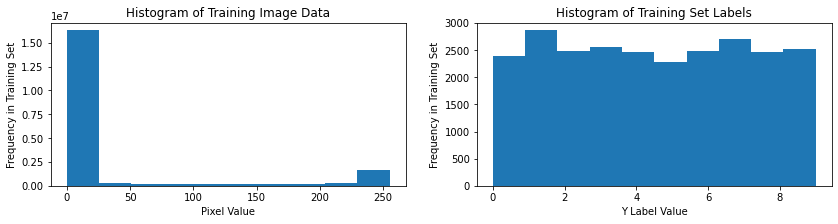

In [8]:
print(f"x_train.shape {x_train.shape}; dtype {x_train.dtype}")
print(f"y_train.shape {y_train.shape}; dtype {y_train.dtype}")
print(f"x_test.shape {x_test.shape}; dtype {x_test.dtype}")
print(f"y_test.shape {y_test.shape}; dtype {y_test.dtype}")

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.hist(x_train.flatten())
ax.set_title("Histogram of Training Image Data")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Pixel Value")

ax = plt.subplot(1, 2, 2)
plt.hist(y_train)
ax.set_title("Histogram of Training Set Labels")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Y Label Value")

plt.show()

Some example images:


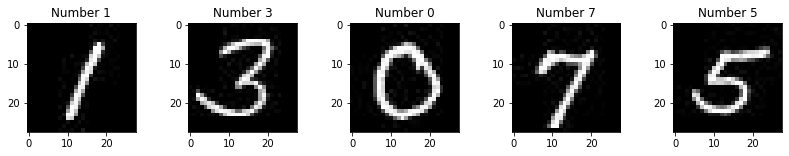

In [9]:
print("Some example images:")
fig = plt.figure(figsize=(14, 2))
for i in range(5):
    fig = plt.subplot(1, 5, i + 1)
    ax = plt.imshow(x_train[i], cmap="gray")
    fig.set_title(f"Number {y_train[i]}")
plt.show()

You should find that the distributions haven't shifted, and the advertised labels still visually match the images!

## Pre-Process the Data for our CNN

We've recovered the dataset from our JPEG files back to the MNIST original format, and verified nothing's majorly broken...

Next, we'll tweak this format for our neural network:

- Normalizing pixel values to improve the numerical conditioning
- One-hot encoding our labels to suit a softmax classifier output of probabilities for each digit
- Adding both a batch dimension (for processing multiple samples in parallel) and a channel dimension (e.g. as if this were a 3-channel RGB image, except single-channel for grayscale) - as well as the X and Y axes.


In [10]:
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]

print("x_train shape:", x_train.shape)
print("input_shape:", input_shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='float32')[y]

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, n_labels)
y_test = to_categorical(y_test, n_labels)

print("n_labels:", n_labels)
print("y_train shape:", y_train.shape)

x_train shape: (25200, 1, 28, 28)
input_shape: (1, 28, 28)
25200 train samples
4800 test samples
n_labels: 10
y_train shape: (25200, 10)


## Build a Model

At its core, the model is a 2D convolutional network with a softmax output layer that'll yield a confidence score for every possible label (e.g. 10 options for digit = 0 to 9).


In [11]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=(3, 3))
        self.max_pool2d = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.flatten1 = nn.Flatten()
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten1(self.dropout1(self.max_pool2d(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(self.dropout2(x))
        return F.softmax(x)

Define training and evaluation script here

In [12]:
def test(model, testloader, device):
    loss_function = F.binary_cross_entropy
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target, reduction='mean').item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            target_index = target.max(1, keepdim=True)[1]
            correct += pred.eq(target_index).sum().item()

    test_loss /= len(testloader.dataset)
    print("val_loss: {:.4f}".format(test_loss))
    print("val_acc: {:.4f}".format(correct/len(testloader.dataset)))   

def train(trainloader, testloader, epochs, num_classes):
    model = Net(num_classes)
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    model.to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    loss_function = F.binary_cross_entropy
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for batch_idx, (x_train, y_train) in enumerate(trainloader):
            data, target = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print("epoch: {}".format(epoch))
        print("train_loss: {:.6f}".format(running_loss / (len(trainloader.dataset))))     
        print("Evaluating model")
        test(model, testloader, device)
    return model

The custom Dataset class below is to allow data loading

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        'Initialization'
        self.labels = labels
        self.data = data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        return X, y

## Fit the Model

In [14]:
%%time
batch_size = 128
epochs = 12
trainloader = torch.utils.data.DataLoader(Dataset(x_train, y_train), batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(Dataset(x_test, y_test), batch_size=1,
                                          shuffle=True )

model = train(trainloader, testloader, epochs = epochs, num_classes = 10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1
train_loss: 0.000937
Evaluating model
val_loss: 0.0525
val_acc: 0.9025
epoch: 2
train_loss: 0.000389
Evaluating model
val_loss: 0.0271
val_acc: 0.9515
epoch: 3
train_loss: 0.000264
Evaluating model
val_loss: 0.0211
val_acc: 0.9602
epoch: 4
train_loss: 0.000204
Evaluating model
val_loss: 0.0154
val_acc: 0.9733
epoch: 5
train_loss: 0.000173
Evaluating model
val_loss: 0.0144
val_acc: 0.9744
epoch: 6
train_loss: 0.000146
Evaluating model
val_loss: 0.0127
val_acc: 0.9800
epoch: 7
train_loss: 0.000130
Evaluating model
val_loss: 0.0115
val_acc: 0.9806
epoch: 8
train_loss: 0.000112
Evaluating model
val_loss: 0.0111
val_acc: 0.9817
epoch: 9
train_loss: 0.000104
Evaluating model
val_loss: 0.0113
val_acc: 0.9808
epoch: 10
train_loss: 0.000098
Evaluating model
val_loss: 0.0101
val_acc: 0.9833
epoch: 11
train_loss: 0.000086
Evaluating model
val_loss: 0.0094
val_acc: 0.9860
epoch: 12
train_loss: 0.000084
Evaluating model
val_loss: 0.0097
val_acc: 0.9846
CPU times: user 7min 59s, sys: 5.98 s

## Save the Trained Model

Torch JIT model allows us to store the inference script along with the model weights

In [15]:
# The export folder needs to be empty, or non-existent
!rm -rf data/model/model.pth
!mkdir data/model

path = './data/model/model.pth'

x = torch.rand((1,1,28,28), dtype= torch.float)
model = model.cpu()
model.eval()
m = torch.jit.trace(model, x)
torch.jit.save(m, path)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Explore Results

Let's take a sample image from the test set, predict the label and plot it!


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Result confidences: [1.1078954e-08 8.0762538e-07 9.9986613e-01 1.1562656e-04 1.7101273e-14
 1.2214634e-12 6.0036530e-14 1.7459630e-05 2.7078530e-08 1.7116562e-12]


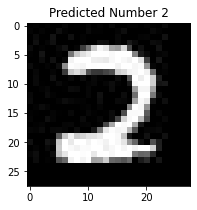

In [16]:
# Choose an image:
label = "2"
filename = os.listdir(f"data/test/digit-{label}")[0]

# Load the image:
img = Image.open(f"data/test/digit-{label}/{filename}")
input_data = np.squeeze(np.asarray(img)).astype(np.float32)/255
input_data = np.expand_dims(np.expand_dims(input_data,0),0)
input_data = torch.tensor(input_data)

# Send to the model:
model = model.cpu()
model.eval()
result = model(input_data)
result = result.detach().numpy()[0]
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(img, cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result)}")
plt.show()

All done!
